<a href="https://colab.research.google.com/github/Pavan042/Covid_19_Image_Classification_CNN_Capstone_Project/blob/main/Covid_19_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid19 Convolutional Neural Networks in hls4ml

## Start with the neccessary imports

In [1]:
import numpy as np
import time
import tensorflow.compat.v2 as tf
#import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [2]:
#test_path = '../dataset/COVID-19_Radiography_Dataset/test'
#train_path = '../dataset/COVID-19_Radiography_Dataset/train'
test_path = '../dataset/COVID-19_Radiography-resized64-png/test'
train_path = '../dataset/COVID-19_Radiography-resized64-png/train'

In [3]:
#manually list labels/classes_name
#labels={'Normal': 0, 'COVID': 1, 'Lung_Opacity': 2, 'Viral Pneumonia': 3}

#automatically scan dir and list the labels/classes_name
import os
labels = []
for i in os.listdir(test_path):
  labels.append(i)
no_labels = len(labels)
print("No of labels: ",no_labels)

# convert a list to a dictionary with indexes as values
# this is required to load test, val and test data correctly
labels_list=labels
print("Labels as list ",labels)
labels = {k: v for v, k in enumerate(labels)}
print("Labels converted to Dict ",labels)

No of labels:  4
Labels as list  ['Normal', 'ViralPneumonia', 'LungOpacity', 'COVID']
Labels converted to Dict  {'Normal': 0, 'ViralPneumonia': 1, 'LungOpacity': 2, 'COVID': 3}


### Generate batches of tensor image data with real-time data augmentation.
### Users need to set batch_size,img_height and img_width before training 

In [4]:
batch_size = 64
img_height = 64
img_width = 64

#gen_train = image.ImageDataGenerator(rescale = 1/255,validation_split = 0.1, horizontal_flip = True)
gen_train = image.ImageDataGenerator(rescale = 1/255,validation_split = 0.1)
gen_test = image.ImageDataGenerator(rescale = 1/255)
SIZE = (img_width,img_height)
input_shape=(img_width,img_height,3)

### gen_train.flow_from_directory Takes the path to a directory & generates batches of augmented data.

In [5]:
print("\n\n Loading train data")
train_data = gen_train.flow_from_directory(batch_size = batch_size, directory = train_path, shuffle = True, classes = labels, target_size = SIZE, subset = "training", class_mode = 'categorical')
print("\n\n Loading validation data")
valid_data = gen_train.flow_from_directory(batch_size = batch_size, directory = train_path, shuffle = True, classes = labels, target_size = SIZE, subset = "validation", class_mode = 'categorical')
#test_data = gen_test.flow_from_directory(batch_size = 1, directory = test_path, shuffle = False, classes =labels, target_size = SIZE, class_mode = 'binary')
print("\n\n Loading test data")
test_data = gen_test.flow_from_directory(batch_size = 1, directory = test_path, shuffle = True, classes =labels, target_size = SIZE, class_mode = 'categorical')



 Loading train data
Found 18590 images belonging to 4 classes.


 Loading validation data
Found 2063 images belonging to 4 classes.


 Loading test data
Found 512 images belonging to 4 classes.


## Prepare Test dataset(X_test) and true Label (Y_test)

In [6]:
class_names = train_data.class_indices
n_classes = len(class_names)
print('\n',"Class Names",class_names)
print('\n',"number of classes",n_classes)
train_size = train_data.n #total training images
print('\n',"training data set count",train_size  )

#print("\n\n Loading test data")
#test_data = gen_test.flow_from_directory(batch_size = 1, directory = test_path, shuffle = True, classes =class_names, target_size = SIZE, class_mode = 'categorical')

"""
# Method 1 to prepare X_test and Y_test from flow_from_directory
test_batch_size=1
import tqdm
test_data.reset()
X_test, Y_test = next(test_data)
for i in tqdm.tqdm(range(int(test_data.n/test_batch_size)-1)): 
  img, label = next(test_data)
  X_test = np.append(X_test, img, axis=0 )
  Y_test = np.append(Y_test, label, axis=0)

print("X test batch shape = {}, Y test batch shape = {} ".format(X_test.shape, Y_test.shape))

test_size = test_data.n #total test images
print('\n',"test data set count",test_size)
"""

# Method 2 to prepare X_test and Y_test from flow_from_directory
# Method 2 seems faster than Method using tqdm
from platform import python_version_tuple

if python_version_tuple()[0] == '3':
    xrange = range
    izip = zip
    imap = map
else:
    from itertools import izip, imap

import numpy as np

# ..
# other code as in question
# ..

x, y = izip(*(test_data[i] for i in xrange(len(test_data))))
X_test, Y_test = np.vstack(x), np.vstack(y)

print("X test batch shape = {}, Y test batch shape = {} ".format(X_test.shape, Y_test.shape))

test_size = test_data.n #total test images
print('\n',"test data set count",test_size)


 Class Names {'Normal': 0, 'ViralPneumonia': 1, 'LungOpacity': 2, 'COVID': 3}

 number of classes 4

 training data set count 18590
X test batch shape = (512, 64, 64, 3), Y test batch shape = (512, 4) 

 test data set count 512


In [7]:
"""
print('\n',{'Covid Negative':len(np.where(train_data .labels==0)[0]),
      'Covid Positive':len(np.where(train_data.labels==1)[0])})
print('\n',{'Covid Negative':len(np.where(valid_data.labels==0)[0]),
      'Covid Positive':len(np.where(valid_data.labels==1)[0])})
print('\n',{'Covid Negative':len(np.where(test_data.labels==0)[0]),
      'Covid Positive':len(np.where(test_data.labels==1)[0])})
"""

print('\n training sets   -',{'Normal':len(np.where(train_data .labels==0)[0]),
      'ViralPneumonia':len(np.where(train_data.labels==1)[0]),
            'Lung_Opacity':len(np.where(train_data.labels==2)[0]),
            'COVID':len(np.where(train_data.labels==3)[0])})
print('\n validation sets -',{'Normal':len(np.where(valid_data.labels==0)[0]),
      'ViralPneumonia':len(np.where(valid_data.labels==1)[0]),
            'Lung_Opacity':len(np.where(valid_data.labels==2)[0]),
           'COVID':len(np.where(valid_data.labels==3)[0])})
print('\n test sets       -',{'Normal':len(np.where(test_data.labels==0)[0]),
      'ViralPneumonia':len(np.where(test_data.labels==1)[0]),
            'Lung_Opacity':len(np.where(test_data.labels==2)[0]),
           'COVID':len(np.where(test_data.labels==3)[0])})


 training sets   - {'Normal': 9058, 'ViralPneumonia': 1096, 'Lung_Opacity': 5296, 'COVID': 3140}

 validation sets - {'Normal': 1006, 'ViralPneumonia': 121, 'Lung_Opacity': 588, 'COVID': 348}

 test sets       - {'Normal': 128, 'ViralPneumonia': 128, 'Lung_Opacity': 128, 'COVID': 128}


## Image Demonstration

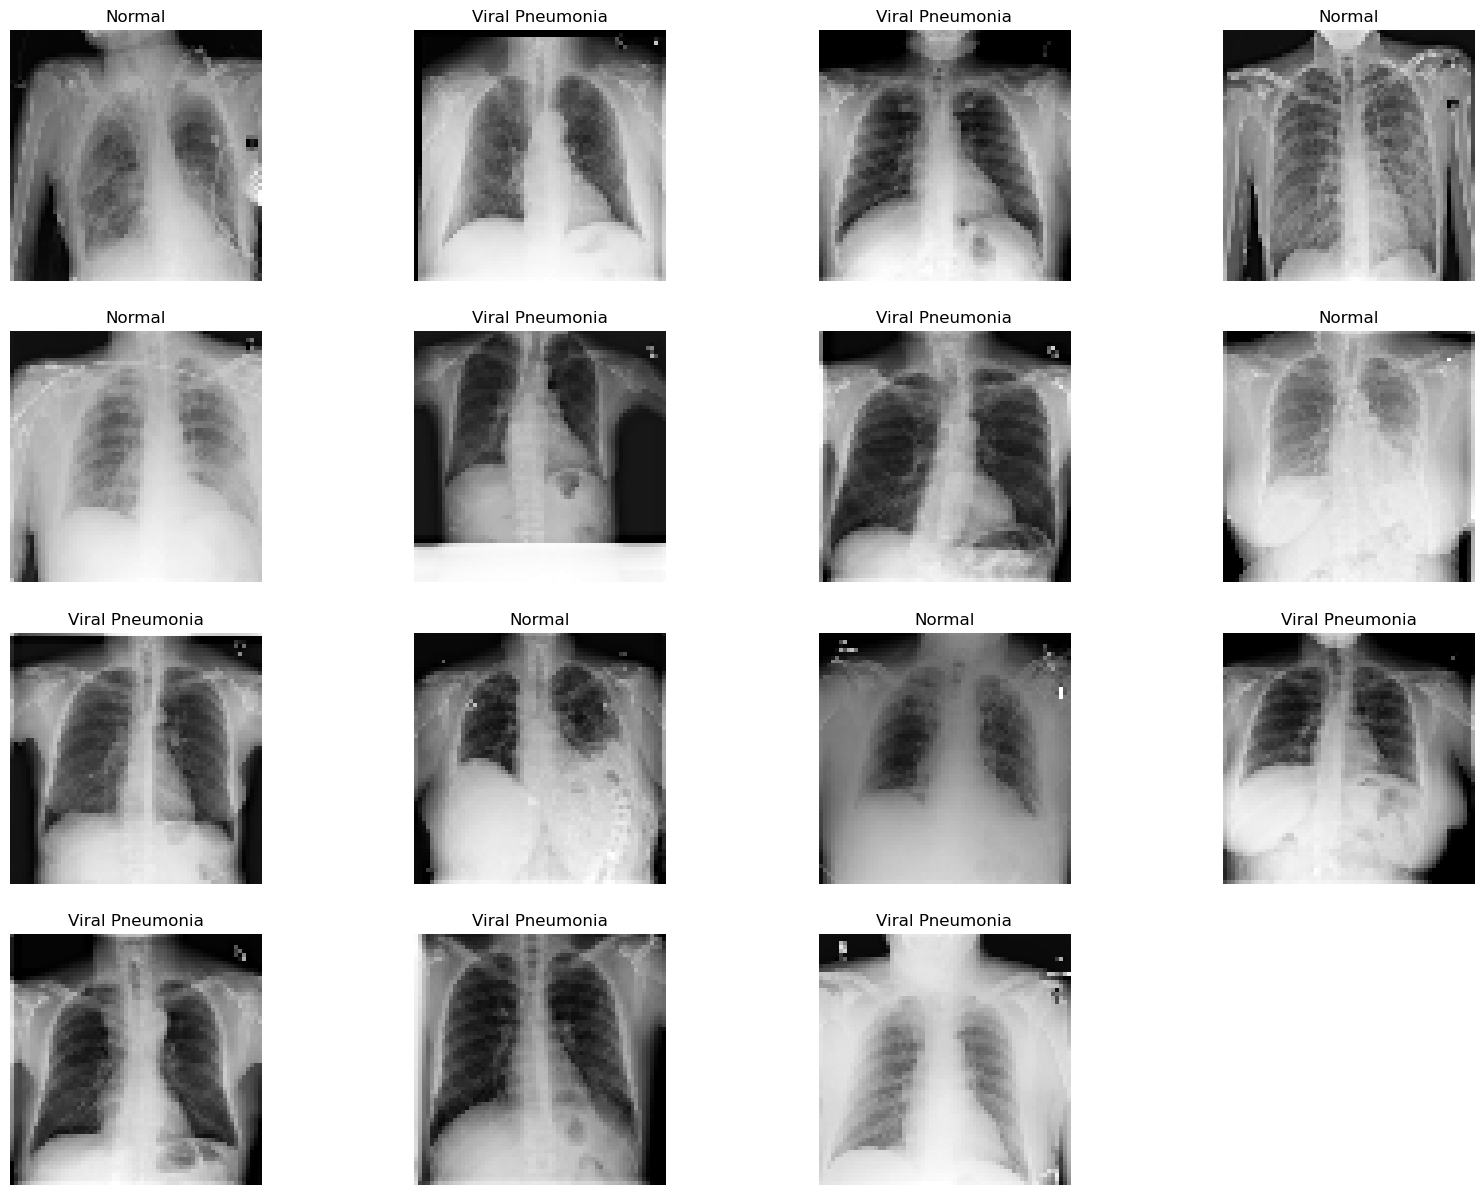

In [8]:
import math
def image_plot(train_data,image_numbers):
    img_feature = train_data[0][0][:image_numbers]
    img_label = train_data[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        #plt.title("Covid Negative" if int(img_label[i][0]) == 0 else "Covid Positive" if int(img_label[i][1]) == 1) # if load as categorical 
        plt.title("Normal" if int(img_label[i][0]) == 0 else "COVID" if int(img_label[i][1]) == 1 else "Lung_Opacity" if int(img_label[i][2]) == 2 else "Viral Pneumonia") # if load as categorical         
        plt.axis("off")

image_plot(train_data,15)

## CNN Model

We then need to define a model. For the lowest possible latency, each layer should have a maximum number of trainable parameters of 4096. This is due to fixed limits in the Vivado compiler, beyond which maximally unrolled (=parallel) compilation will fail. This will allow us to use `strategy = 'latency'` in the hls4ml part, rather than `strategy = 'resource'`, in turn resulting in lower latency

In [9]:
#manually setting CNN model, ChipSkywalker, 
#We will use for loop to automate the model building 

#model1 = Sequential()
#model1.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (224,224,3)))
#model1.add(MaxPool2D())

#model1.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
#model1.add(MaxPool2D())

#model1.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
#model1.add(MaxPool2D())

#model1.add(Flatten())
#model1.add(Dense(128, activation = 'relu'))
#model1.add(Dense(64, activation = 'relu'))
#model1.add(Dense(no_labels, activation = 'softmax'))

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Model

#if reset cuda memory is required set 1, pip install numba in advance
#pip install numba
RESET_CUDA_MEM = 0
DISABLE_CUDA=0

if RESET_CUDA_MEM==1:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()

# disable CUDA GPU to use CPU, for example if GPU is out of memory but your CPU has more memory
# note you need to restart the kernel (kernel -> restart kernel) to take effect 
if DISABLE_CUDA==1:
    import os
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# we move TARGET_SPARSITY here, so user could adjust it with CNN model, since pruning affect accuracy more
# default TARGET_SPARSITY
TARGET_SPARSITY=0.5 # TARGET % to prune (by setting Weights to 0)

USE_VGG16_LIKE = False #setting True will use VGG16 like model, setting Flase will use traditional CNN, default set as False

#***************************************************
# Target FPGA device part number 
#*************************************************** 

HLS_REPORT_FORMAT_2023_2=0 # HLS 2023.2 format move utilization to column 6, 2020.2 is at column 5
#TARGET_FPGA_DEVICE='xczu7ev-ffvc1156-2-e' # ZCU106 MPSoC
#REPORT_USE_CLB=1  # MPSoC report uses CLB as unit
TARGET_FPGA_DEVICE='xc7z020clg484-1'  # ZED Zynq
REPORT_USE_CLB=0  # Zynq report uses Slice as unit, MPSoC use 1

# **** specify which model you want to use
# USE_MODEL_NUMER = 0 , largest model but could achieve very high test accuracy >90
# USE_MODEL_NUMER = 1 , large model test accuracy > 86% but could not fit into the low cost SoC FPGA 
# USE_MODEL_NUMER = 2 , smaller model like VGG16, hls quantized accuracy ~78%, utilization high, could not fit into the low cost SoC FPGA
# USE_MODEL_NUMER = 3 , hls4ml Quantized accuracy ~70%, but could fit into the low cost SoC FPGA(zedboard 7z0202)
# USE_MODEL_NUMER = 4, improves 3 , hls4ml Quantized accuracy ~74-77%, but still could fit into the low cost SoC FPGA(zedboard 7z0202)

USE_MODEL_NUMER = 4

if USE_MODEL_NUMER == 1:
    # first try to lower parameter(reducing BRAM to use smaller FPGA device) while try to keep accuracy
    filters_per_conv_layer = [64, 6, 32,12] 
    neurons_per_dense_layer = [16,128]
    USE_VGG16_LIKE = False #setting True will use VGG16 like model, setting Flase will use traditional CNN, default set as False
    TARGET_SPARSITY=0.5 # TARGET % to prune (by setting Weights to 0)

    # HLS Test Accuracy
    #Float Pruned Keras accuracy = 0.869140625 , Quantized Pruned QKeras accuracy = 0.85
    #Accuracy hls4ml Float Keras : 87.109375 % Accuracy hls4ml Quantized QKeras: 86.1328125 %

    #Resource usage and latency: Pruned + Float
    #'Estimated clock ns': '  4.429 ns'
    #,{'bram': 249.5,'bram_Util%': 178.21,'dsp': 220,'dsp_Util%': 100.0,'ff': 284946,'ff_Util%': 267.81,
    #'latency_clks': 43441,'latency_ii': 36868,'latency_ms': 217.205 ms,'lut': 330825,'lut_Util%': 621.85}

    #Resource usage and latency: Pruned + quantized
    #'Estimated clock ns': '  4.429 ns
    #'{'bram': 256.5,'bram_Util%': 183.21,'dsp': 220,'dsp_Util%': 100.0,'ff': 160128,'ff_Util%': 150.5,
    #'latency_clks': 39345,'latency_ii': 32772,'latency_ms': '  196.725 ms','lut': 119159,'lut_Util%': 223.98}

elif USE_MODEL_NUMER == 2:
    # second try to lower parameter(reducing BRAM to use smaller FPGA device) while try to keep accuracy
    filters_per_conv_layer = [8, 4, 8,4, 8, 4] 
    neurons_per_dense_layer = [16,32]
    TARGET_SPARSITY=0.5 # TARGET % to prune (by setting Weights to 0)
    USE_VGG16_LIKE = True
    # result with TARGET_SPARSITY=0.5 image 64x64

    #Test Accuracy
    #Float Pruned Keras accuracy = 0.83203125 , Quantized Pruned QKeras accuracy = 0.779296875
    #Accuracy hls4ml Float Keras  : 83.3984375 %,Accuracy hls4ml Quantized QKeras: 78.3203125 %

    # utilization based on 7z020 
    #Resource usage and latency: Pruned + Float
    #{'Estimated clock ns': '4.429 ns','bram': 71.5,'bram_Util%': 51.07,'dsp': 220,'dsp_Util%': 100.0,'ff': 80887,'ff_Util%': 76.02,
    #'latency_clks': 35809,'latency_ii': 34600,'latency_ms': '  0.179 ms','lut': 64490,'lut_Util%': 121.22}

    #Resource usage and latency: Pruned + quantized
    #{'Estimated clock ns': '4.429 ns','bram': 80.5,'bram_Util%': 57.5,'dsp': 92,'dsp_Util%': 41.82,'ff': 61350,'ff_Util%': 57.66,
    #'latency_clks': 33974,'latency_ii': 32772,'latency_ms': '0.170 ms','lut': 36386,'lut_Util%': 68.39}

elif USE_MODEL_NUMER == 3:
    # third try to lower parameter(reducing BRAM to use smaller FPGA device) while try to keep accuracy
    filters_per_conv_layer = [4,2,2] 
    neurons_per_dense_layer = [4,16]  
    USE_VGG16_LIKE = False #setting True will use VGG16 like model, setting Flase will use traditional CNN, default set as False
    TARGET_SPARSITY=0.25 # TARGET % to prune (by setting Weights to 0)

    #Test Accuracy
    #Float Pruned Keras accuracy = 0.748046875 , Quantized Pruned QKeras accuracy = 0.69140625
    #Accuracy hls4ml Float Keras     : 75.78125 % Accuracy hls4ml Quantized QKeras: 69.140625 %

    #Resource usage and latency: Pruned + Float
    #{'Estimated clock ns': '  4.429 ns','bram': 23.0,'bram_Util%': 16.43,'dsp': 171,'dsp_Util%': 77.73,'ff': 19079,'ff_Util%': 17.93,
    #'latency_clks': 33191,'latency_ii': 32772,'latency_ms': '  0.166 ms','lut': 9764,'lut_Util%': 18.35}

    #Resource usage and latency: Pruned + quantized
    #{'Estimated clock ns': '  4.429 ns','bram': 23.5,'bram_Util%': 16.79,'dsp': 58,'dsp_Util%': 26.36,'ff': 20177,'ff_Util%': 18.96,...
    #'latency_ii': 32772,'latency_ms': '  0.166 ms','lut': 11933,'lut_Util%': 22.43}

elif USE_MODEL_NUMER == 4:
    # third try to lower parameter(reducing BRAM to use smaller FPGA device) while try to keep accuracy
    filters_per_conv_layer = [4,2,2] 
    neurons_per_dense_layer = [6,24]  
    USE_VGG16_LIKE = False #setting True will use VGG16 like model, setting Flase will use traditional CNN, default set as False
    TARGET_SPARSITY=0.25 # TARGET % to prune (by setting Weights to 0)

    #Test Accuracy
    #Float Pruned Keras accuracy = 0.78125 , Quantized Pruned QKeras accuracy = 0.76171875
    #Accuracy hls4ml Float Keras : 79.8828125 % ; Accuracy hls4ml Quantized QKeras: 75.9765625 %

    #Resource usage and latency: Pruned + Float
    #{'Estimated clock ns': '  4.429 ns','bram': 34.0,'bram_Util%': 24.29,'dsp': 192,'dsp_Util%': 87.27,'ff': 30745,'ff_Util%': 28.9,
    #'latency_clks': 33486,'latency_ii': 32772,'latency_ms': '  0.167 ms','lut': 12892,'lut_Util%': 24.23}

    #Resource usage and latency: Pruned + quantized
    #{'Estimated clock ns': '  4.429 ns','bram': 34.5,'bram_Util%': 24.64,'dsp': 65,'dsp_Util%': 29.55,'ff': 29906,'ff_Util%': 28.11,
    #'latency_ii': 28676,'latency_ms': '  0.147 ms','lut': 15660,'lut_Util%': 29.44}

else :
    #initial model configuration
    filters_per_conv_layer = [64, 64, 32] 
    neurons_per_dense_layer = [8,128]
    USE_VGG16_LIKE = False

x = x_in = Input(input_shape)

# For loop to create a typical CNN model
for i, f in enumerate(filters_per_conv_layer):
    print(('Adding convolutional block {} with N={} filters').format(i, f))
    x = Conv2D(
        int(f),
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=False,
        name='conv_{}'.format(i)
    )(x)
    x = BatchNormalization(name='bn_conv_{}'.format(i))(x)
    x = Activation('relu', name='conv_act_%i' % i)(x)
    if USE_VGG16_LIKE :
        if(i%2==1) : # for VGG16-like 
            x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
    else :
        x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
x = Flatten()(x)

for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding dense block {} with N={} neurons').format(i, n))
    x = Dense(n, kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), name='dense_%i' % i, use_bias=False)(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = Activation('relu', name='dense_act_%i' % i)(x)
x = Dense(int(n_classes), name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)

model = Model(inputs=[x_in], outputs=[x_out], name='keras_baseline')

model.summary()

Adding convolutional block 0 with N=4 filters
Adding convolutional block 1 with N=2 filters
Adding convolutional block 2 with N=2 filters
Adding dense block 0 with N=6 neurons
Adding dense block 1 with N=24 neurons
Model: "keras_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv_0 (Conv2D)             (None, 62, 62, 4)         108       
                                                                 
 bn_conv_0 (BatchNormalizati  (None, 62, 62, 4)        16        
 on)                                                             
                                                                 
 conv_act_0 (Activation)     (None, 62, 62, 4)         0         
                                                                 
 pool_0 (MaxPooling2D)       (None,

2024-10-21 13:53:23.767399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 13:53:23.827177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 703 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:65:00.0, compute capability: 7.5


#### For metrics parameter of the model.compile, we can mention evaluation metrics we want the model to return. Here we shall write accuracy.
- **Use model.compile and compile it with loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"].**

In [10]:
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics='accuracy')
#model.compile(optimizer="adam", loss='SparseCategoricalCrossentropy', metrics='accuracy')

- **Use fit method of the model to start training on the train_data. Use validation_data =(valid_data).**

In [11]:
#n_epochs = 20
#skip non float model fitting 
#history = model.fit(train_data, epochs=n_epochs, validation_data=valid_data)

#### Lets check if this model can be implemented completely unrolled (=parallel)

In [12]:
for layer in model.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name, layersize))  # 0 = weights, 1 = biases
        if layersize > 4096:  # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name, layersize))

conv_0: 108
conv_1: 72
conv_2: 36
dense_0: 432
dense_1: 144
output_dense: 96


#### Prune dense and convolutional layers

In [13]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

NSTEPS = int(train_size * 0.9) // batch_size  # 90% train, 10% validation in 10-fold cross validation
print('Number of training steps per epoch is {}'.format(NSTEPS))

#TARGET_SPARSITY=0.2 # TARGET % to prune (by setting Weights to 0)

# Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs,
# ending by the 10th epoch
def pruneFunction(layer):
    pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(
            initial_sparsity=0.0, final_sparsity=TARGET_SPARSITY, begin_step=NSTEPS * 2, end_step=NSTEPS * 10, frequency=NSTEPS
        )
    }
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name != 'output_dense':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer


model_pruned = tf.keras.models.clone_model(model, clone_function=pruneFunction)

Number of training steps per epoch is 261
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Train baseline (the float pruned model)

We're now ready to train the model! We defined the batch size and n epochs above. We won't use callbacks that store the best weights only, since this might select a weight configuration that has not yet reached 50% sparsity.

In [14]:
import time

train = True  # True if you want to retrain, false if you want to load a previsously trained model

n_epochs = 50

if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

    model_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])  
    #model_pruned.compile(loss='SparseCategoricalCrossentropy', optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=n_epochs/2, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    history = model_pruned.fit(train_data, epochs=n_epochs, validation_data=valid_data, callbacks=callbacks)
    
    end = time.time()

    print('It took {} minutes to train Keras model'.format((end - start) / 60.0))

    model_pruned.save('pruned_cnn_model.h5')

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_pruned = tf.keras.models.load_model('pruned_cnn_model.h5', custom_objects=co)

Epoch 1/50


2024-10-21 13:53:27.527157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-10-21 13:53:27.749123: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7cf0b405fa80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-21 13:53:27.749157: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-10-21 13:53:27.755289: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-21 13:53:27.833333: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


291/291 [==============================] - 10s 21ms/step - loss: 0.9204 - accuracy: 0.6313 - val_loss: 0.8474 - val_accuracy: 0.6660 - lr: 0.0030
Epoch 2/50
291/291 [==============================] - 6s 19ms/step - loss: 0.7046 - accuracy: 0.7254 - val_loss: 0.7023 - val_accuracy: 0.7072 - lr: 0.0030
Epoch 3/50
291/291 [==============================] - 6s 19ms/step - loss: 0.6585 - accuracy: 0.7471 - val_loss: 0.6851 - val_accuracy: 0.7407 - lr: 0.0030
Epoch 4/50
291/291 [==============================] - 6s 19ms/step - loss: 0.6354 - accuracy: 0.7547 - val_loss: 0.7540 - val_accuracy: 0.6956 - lr: 0.0030
Epoch 5/50
291/291 [==============================] - 6s 19ms/step - loss: 0.6133 - accuracy: 0.7639 - val_loss: 0.8213 - val_accuracy: 0.6655 - lr: 0.0030
Epoch 6/50
289/291 [============================>.] - ETA: 0s - loss: 0.6016 - accuracy: 0.7689
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
291/291 [==============================] - 6s 19ms/step - l

### Float Pruned Model Accuracy/Loss

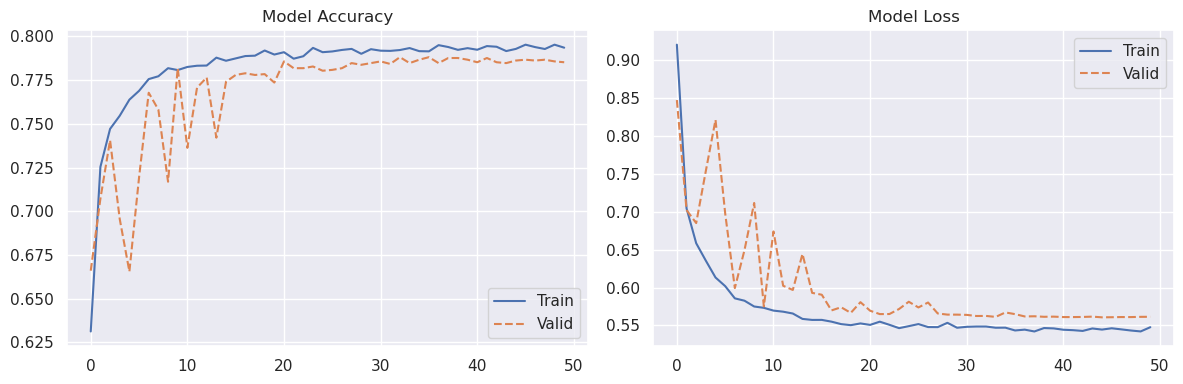

In [15]:
import seaborn as sns
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='Train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='Valid', linestyle = 'dashed')
plt.title('Model Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='Train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='Valid', linestyle = 'dashed')
plt.title('Model Loss')
plt.tight_layout()

## Quantization and the fused Conv2D+BatchNormalization layer in QKeras
Let's now create a pruned an quantized model using QKeras. For this, we will use a fused Convolutional and BatchNormalization (BN) layer from QKeras, which will further speed up the implementation when we implement the model using hls4ml. 
There is currently no fused Dense+BatchNoralization layer available in QKeras, so we'll use Keras BatchNormalization when BN follows a Dense layer for now. We'll use the same precision everywhere, namely a bit width of 6 and 0 integer bits (this will be implemented as``<6,1>`` in hls4ml, due to the missing sign-bit). For now, make sure to set ```use_bias=True``` in ```QConv2DBatchnorm``` to avoid problems during synthesis.

In [16]:
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm

x = x_in = Input(shape=input_shape)

for i, f in enumerate(filters_per_conv_layer):
    print(('Adding fused QConv+BN block {} with N={} filters').format(i, f))
    x = QConv2DBatchnorm(
        int(f),
        kernel_size=(3, 3),
        strides=(1, 1),
        #kernel_quantizer="quantized_bits(6,0,alpha=1)",
        #bias_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_quantizer="quantized_bits(8,3,alpha=1)",
        bias_quantizer="quantized_bits(8,3,alpha=1)",         
        #kernel_quantizer="quantized_bits(8,3)",
        #bias_quantizer="quantized_bits(8,3)",          
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=True,
        name='fused_convbn_{}'.format(i),
    )(x)
    x = QActivation('quantized_relu(16)', name='conv_act_%i' % i)(x)
    if USE_VGG16_LIKE :
        if(i%2==1) : # for VGG16-like     
            x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
    else :
        x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
x = Flatten()(x)

for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding QDense block {} with N={} neurons').format(i, n))
    x = QDense(
        n,
        #kernel_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_quantizer="quantized_bits(8,3,alpha=1)",
        bias_quantizer="quantized_bits(8,3,alpha=1)",             
        #kernel_quantizer="quantized_bits(8,3)",          
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        name='dense_%i' % i,
        use_bias=False,
    )(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    #x = QActivation('quantized_relu(6)', name='dense_act_%i' % i)(x)
    x = QActivation('quantized_relu(16)', name='dense_act_%i' % i)(x)    
x = Dense(int(n_classes), name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)
qmodel = Model(inputs=[x_in], outputs=[x_out], name='qkeras')

Adding fused QConv+BN block 0 with N=4 filters
Adding fused QConv+BN block 1 with N=2 filters
Adding fused QConv+BN block 2 with N=2 filters
Adding QDense block 0 with N=6 neurons
Adding QDense block 1 with N=24 neurons


In [17]:
qmodel.summary()

Model: "qkeras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 fused_convbn_0 (QConv2DBatc  (None, 62, 62, 4)        129       
 hnorm)                                                          
                                                                 
 conv_act_0 (QActivation)    (None, 62, 62, 4)         0         
                                                                 
 pool_0 (MaxPooling2D)       (None, 31, 31, 4)         0         
                                                                 
 fused_convbn_1 (QConv2DBatc  (None, 29, 29, 2)        83        
 hnorm)                                                          
                                                                 
 conv_act_1 (QActivation)    (None, 29, 29, 2)         0    

### Train Quanized Pruned Model

In [18]:
qmodel_pruned = tf.keras.models.clone_model(qmodel, clone_function=pruneFunction)

In [19]:
train = True

n_epochs = 70
if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    qmodel_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"]) 
    #qmodel_pruned.compile(loss='SparseCategoricalCrossentropy', optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=n_epochs/2, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    history = qmodel_pruned.fit(train_data, epochs=n_epochs, validation_data=valid_data, callbacks=callbacks, verbose=1)
    end = time.time()
    print('\n It took {} minutes to train!\n'.format((end - start) / 60.0))

    qmodel_pruned.save('quantized_pruned_cnn_model.h5')

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    qmodel_pruned = tf.keras.models.load_model('quantized_pruned_cnn_model.h5', custom_objects=co)

Epoch 1/70


2024-10-21 13:58:14.068449: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/qkeras/conv_act_2/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


291/291 [==============================] - 10s 21ms/step - loss: 1.0097 - accuracy: 0.5925 - val_loss: 1.0267 - val_accuracy: 0.5957 - lr: 0.0030
Epoch 2/70
291/291 [==============================] - 6s 19ms/step - loss: 0.8161 - accuracy: 0.6765 - val_loss: 0.7878 - val_accuracy: 0.6815 - lr: 0.0030
Epoch 3/70
291/291 [==============================] - 6s 19ms/step - loss: 0.7527 - accuracy: 0.7023 - val_loss: 0.7493 - val_accuracy: 0.7009 - lr: 0.0030
Epoch 4/70
291/291 [==============================] - 6s 19ms/step - loss: 0.7206 - accuracy: 0.7148 - val_loss: 0.6997 - val_accuracy: 0.7237 - lr: 0.0030
Epoch 5/70
291/291 [==============================] - 6s 19ms/step - loss: 0.6958 - accuracy: 0.7280 - val_loss: 0.6747 - val_accuracy: 0.7276 - lr: 0.0030
Epoch 6/70
291/291 [==============================] - 6s 19ms/step - loss: 0.6773 - accuracy: 0.7367 - val_loss: 0.7463 - val_accuracy: 0.6951 - lr: 0.0030
Epoch 7/70
291/291 [==============================] - 6s 19ms/step - loss:

In [20]:
# Print the quantized layers
from qkeras.autoqkeras.utils import print_qmodel_summary

print_qmodel_summary(qmodel)

fused_convbn_0       f=4 quantized_bits(8,3,0,alpha=1) quantized_bits(8,3,0,alpha=1) 
conv_act_0           quantized_relu(16)
fused_convbn_1       f=2 quantized_bits(8,3,0,alpha=1) quantized_bits(8,3,0,alpha=1) 
conv_act_1           quantized_relu(16)
fused_convbn_2       f=2 quantized_bits(8,3,0,alpha=1) quantized_bits(8,3,0,alpha=1) 
conv_act_2           quantized_relu(16)
dense_0              u=6 quantized_bits(8,3,0,alpha=1) quantized_bits(8,3,0,alpha=1) 
bn_dense_0           is normal keras bn layer
dense_act_0          quantized_relu(16)
dense_1              u=24 quantized_bits(8,3,0,alpha=1) quantized_bits(8,3,0,alpha=1) 
bn_dense_1           is normal keras bn layer
dense_act_1          quantized_relu(16)



You see that a bias quantizer is defined, although we are not using a bias term for the layers. This is set automatically by QKeras. In addition, you'll note that ``alpha='1'``. This sets the weight scale per channel to 1 (no scaling). The default is ``alpha='auto_po2'``, which sets the weight scale per channel to be a power-of-2, such that an actual hardware implementation can be performed by just shifting the result of the convolutional/dense layer to the right or left by checking the sign of the scale and then taking the log2 of the scale.

Let's now prune and train this model! If you want, you can also train the unpruned version, ``qmodel`` and see how the performance compares. We will stick to the pruned one here. Again, we do not use a model checkpoint which stores the best weights, in order to ensure the model is trained to the desired sparsity.

### Quantized Pruned model Accuracy/Loss

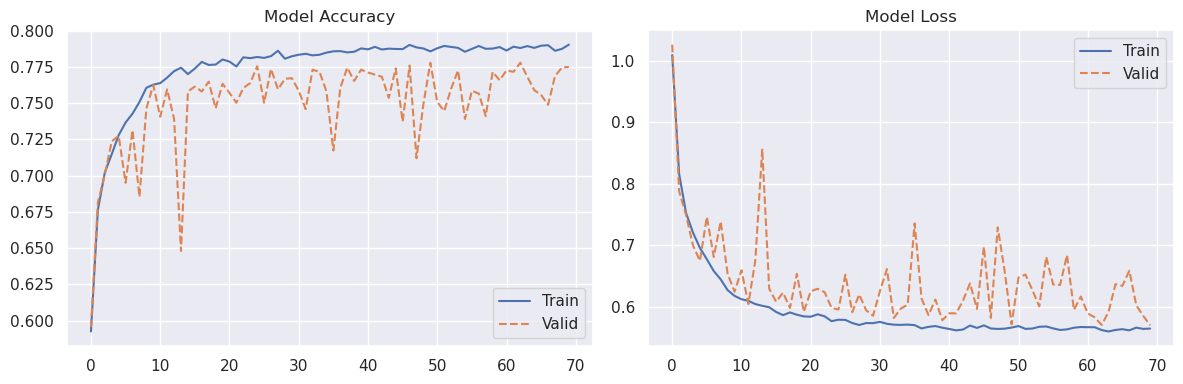

In [21]:
import seaborn as sns
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='Train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='Valid', linestyle = 'dashed')
plt.title('Model Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='Train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='Valid', linestyle = 'dashed')
plt.title('Model Loss')
plt.tight_layout()

Performance
Let's look at some ROC curves to compare the performance. Lets choose a few numbers so it doesn't get confusing. Feel free to change the numbers in labels.

In [22]:
predict_baseline = model_pruned.predict(X_test)
test_score_baseline = model_pruned.evaluate(X_test, Y_test)

predict_qkeras = qmodel_pruned.predict(X_test)
test_score_qkeras = qmodel_pruned.evaluate(X_test, Y_test)

#print('\nFloat Pruned Keras accuracy = {} \n'.format(test_score_baseline[1]))
print('\nFloat Pruned Keras accuracy = {} , Quantized Pruned QKeras accuracy = {}\n'.format(test_score_baseline[1], test_score_qkeras[1]))

16/16 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.7559

Float Pruned Keras accuracy = 0.763671875 , Quantized Pruned QKeras accuracy = 0.755859375



Plotting ROC for labels ['0', '1', '2', '3']


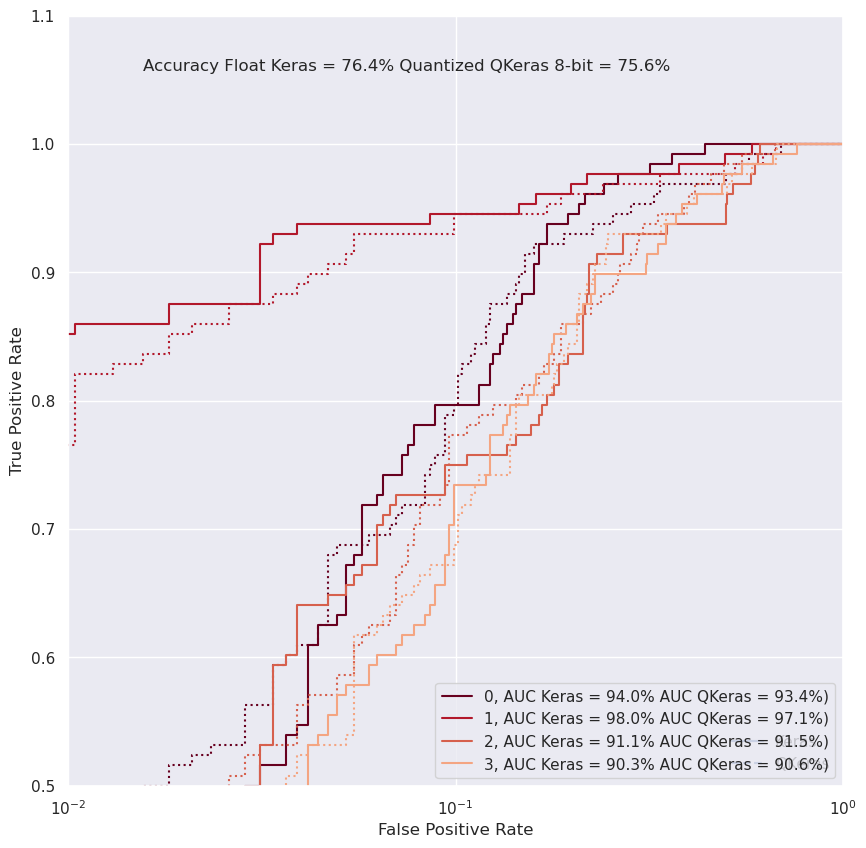

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


labels = ['%i' % nr for nr in range(0, n_classes)]  # If you want to look at all the labels
# labels = ['0','1','9'] # Look at only a few labels, here for digits 0, 1 and 9
print('Plotting ROC for labels {}'.format(labels))

df = pd.DataFrame()
df_q = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}
fpr_q = {}
tpr_q = {}
auc1_q = {}
%matplotlib inline
colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
fig, ax = plt.subplots(figsize=(10, 10))
for i, label in enumerate(labels):
    df[label] = Y_test[:, int(label)]
    df[label + '_pred'] = predict_baseline[:, int(label)]
    fpr[label], tpr[label], threshold = metrics.roc_curve(df[label], df[label + '_pred'])
    auc1[label] = metrics.auc(fpr[label], tpr[label])

    df_q[label] = Y_test[:, int(label)]
    df_q[label + '_pred'] = predict_qkeras[:, int(label)]
    fpr_q[label], tpr_q[label], threshold_q = metrics.roc_curve(df_q[label], df_q[label + '_pred'])
    auc1_q[label] = metrics.auc(fpr_q[label], tpr_q[label])

    plt.plot(
        fpr[label],
        tpr[label],
        label=r'{}, AUC Keras = {:.1f}% AUC QKeras = {:.1f}%)'.format(label, auc1[label] * 100, auc1_q[label] * 100),
        linewidth=1.5,
        c=colors[i],
        linestyle='solid',
    )
    plt.plot(fpr_q[label], tpr_q[label], linewidth=1.5, c=colors[i], linestyle='dotted')

plt.semilogx()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.xlim(0.01, 1.0)
plt.ylim(0.5, 1.1)
plt.legend(loc='lower right')
plt.figtext(
    0.2,
    0.83,
    r'Accuracy Float Keras = {:.1f}% Quantized QKeras 8-bit = {:.1f}%'.format(test_score_baseline[1] * 100, test_score_qkeras[1] * 100),
    wrap=True,
    horizontalalignment='left',
    verticalalignment='center',
)
from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['Keras', 'QKeras'], loc='lower right', frameon=False)
ax.add_artist(leg)

### Check sparsity Let's also check the per-layer sparsity:

Layer prune_low_magnitude_conv_0: % of zeros = 0.25
Layer bn_conv_0: % of zeros = 0.0
Layer prune_low_magnitude_conv_1: % of zeros = 0.25
Layer bn_conv_1: % of zeros = 0.0
Layer prune_low_magnitude_conv_2: % of zeros = 0.25
Layer bn_conv_2: % of zeros = 0.0
Layer prune_low_magnitude_dense_0: % of zeros = 0.25
Layer bn_dense_0: % of zeros = 0.0
Layer prune_low_magnitude_dense_1: % of zeros = 0.25
Layer bn_dense_1: % of zeros = 0.0
Layer output_dense: % of zeros = 0.0
Layer prune_low_magnitude_fused_convbn_0: % of zeros = 0.25
Layer prune_low_magnitude_fused_convbn_1: % of zeros = 0.25
Layer prune_low_magnitude_fused_convbn_2: % of zeros = 0.25
Layer prune_low_magnitude_dense_0: % of zeros = 0.25
Layer bn_dense_0: % of zeros = 0.0
Layer prune_low_magnitude_dense_1: % of zeros = 0.25
Layer bn_dense_1: % of zeros = 0.0
Layer output_dense: % of zeros = 0.0


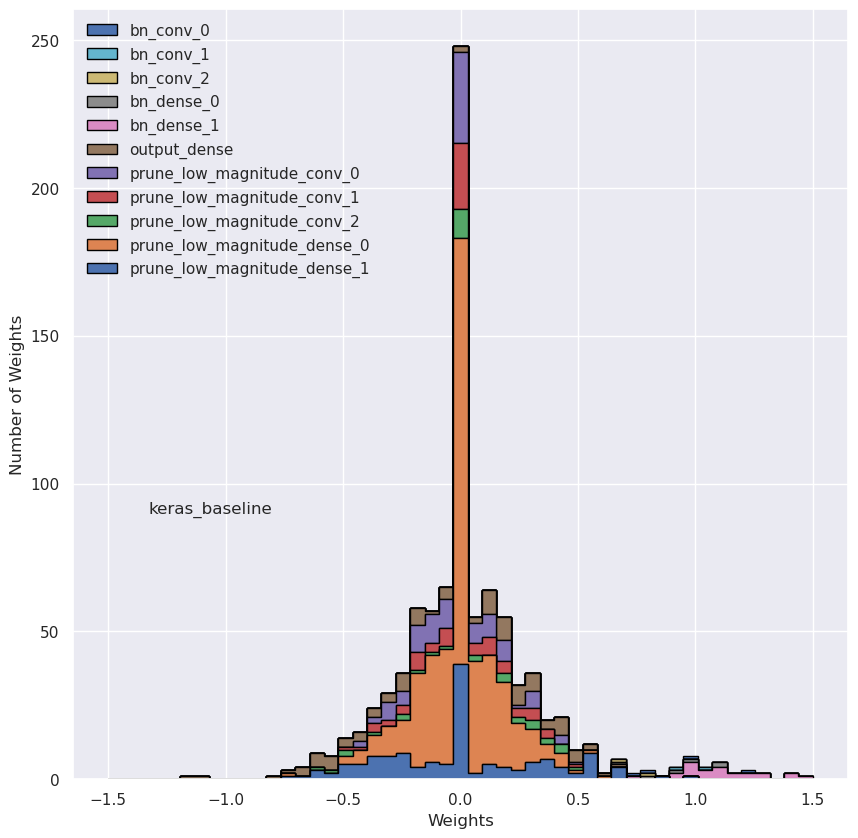

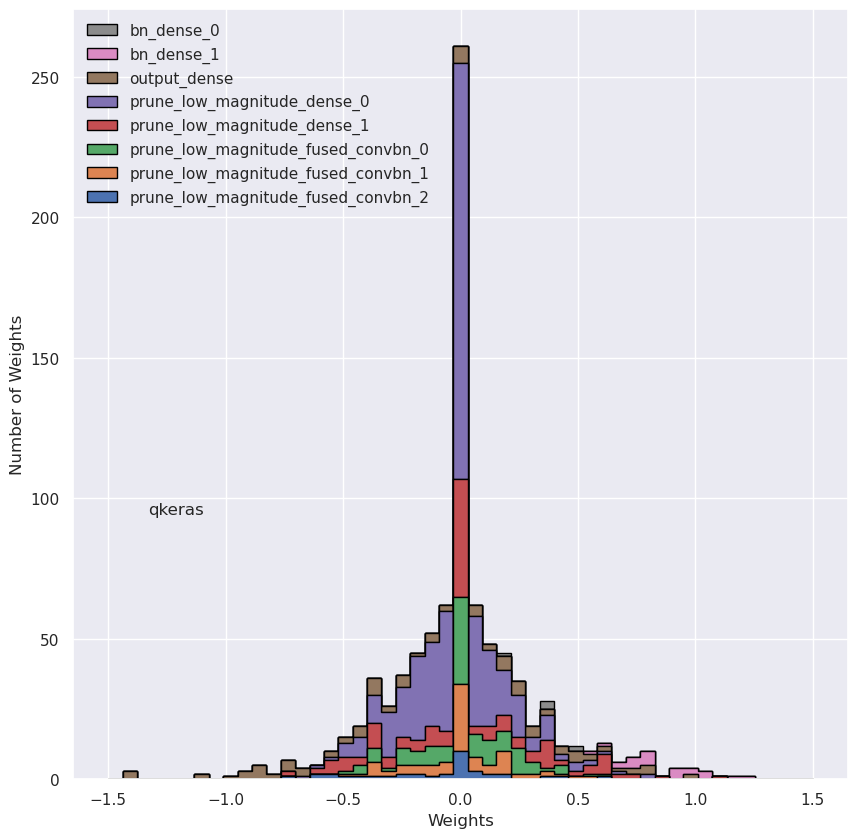

In [24]:
def doWeights(model):
    allWeightsByLayer = {}
    for layer in model.layers:
        if (layer._name).find("batch") != -1 or len(layer.get_weights()) < 1:
            continue
        weights = layer.weights[0].numpy().flatten()
        allWeightsByLayer[layer._name] = weights
        print('Layer {}: % of zeros = {}'.format(layer._name, np.sum(weights == 0) / np.size(weights)))

    labelsW = []
    histosW = []

    for key in reversed(sorted(allWeightsByLayer.keys())):
        labelsW.append(key)
        histosW.append(allWeightsByLayer[key])

    fig = plt.figure(figsize=(10, 10))
    bins = np.linspace(-1.5, 1.5, 50)
    plt.hist(histosW, bins, histtype='stepfilled', stacked=True, label=labelsW, edgecolor='black')
    plt.legend(frameon=False, loc='upper left')
    plt.ylabel('Number of Weights')
    plt.xlabel('Weights')
    plt.figtext(0.2, 0.38, model._name, wrap=True, horizontalalignment='left', verticalalignment='center')


doWeights(model_pruned)
doWeights(qmodel_pruned)

### We see that 50%/25% of the weights per layer are set to zero, as expected. Now, let's synthesize the floating point Keras model and the QKeras quantized model!

CNNs in hls4ml
In this part, we will take the two models we trained above (the floating-point 32 Keras model and the n-bit QKeras model), and synthesize them with hls4ml. Although your models are probably already in memory, let's load them from scratch. We need to pass the appropriate custom QKeras/pruning layers when loading, and remove the pruning parameters that were saved together with the model.

In [25]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude

model = tf.keras.models.load_model('pruned_cnn_model.h5', custom_objects=co)
model = strip_pruning(model)

qmodel = tf.keras.models.load_model('quantized_pruned_cnn_model.h5', custom_objects=co)
qmodel = strip_pruning(qmodel)

Now, we need to define the hls4ml and Vivado configurations. Two things will change with respect to what was done in the previous exercises. First, we will use IOType= 'io_stream' in the Vivado configuration.

****You must use IOType= 'io_stream' if attempting to synthesize a large convolutional neural network.****

The CNN implementation in hls4ml is based on streams, which are synthesized in hardware as first in, first out (FIFO) buffers. Shift registers are used to keep track of the last <kernel height - 1> rows of input pixels, and maintains a shifting snapshot of the convolution kernel.

This is illustrated in the gif below. Here, the input image is at the top-left and the output image at the bottom left. The top right image shows the internal state of the shift registers and convolutional kernel. The red square indicates the current pixels contained within the convolutional kernel.



Lastly, we will use ['Strategy'] = 'Latency' for all the layers in the hls4ml configuration. If one layer would have >4096 elements, we sould set ['Strategy'] = 'Resource' for that layer, or increase the reuse factor by hand. You can find examples of how to do this below.


In [26]:
import hls4ml
import plotting
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


# First, the baseline model
hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['Model']['ReuseFactor'] = 1

# Create an entry for each layer, here you can for instance change the strategy for a layer to 'resource'
# or increase the reuse factor individually for large layers.
# In this case, we designed the model to be small enough for a fully parallel implementation
# so we use the latency strategy and reuse factor of 1 for all layers.
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Latency'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 1
# If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
#plotting.print_dict(hls_config)
#for k in hls_config:
#   print('\n',k,hls_config[k],'\n')

import json
print(json.dumps(hls_config, indent = 4)) #chipSkywalker 2024.07.04 to fix no attribute print_dict error

#cfg = hls4ml.converters.create_config(backend='Vivado')
cfg = hls4ml.converters.create_config(backend='Vitis')  # chipSkywalker modified to use Vitis HLS
cfg['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg['HLSConfig'] = hls_config
cfg['KerasModel'] = model
cfg['OutputDir'] = 'pruned_cnn/'
#cfg['Part'] = 'xc7z020clg484-1' #zedboard
cfg['Part'] = TARGET_FPGA_DEVICE   # chipSkywalker use Target Device set at beginning
#cfg['XilinxPart'] = TARGET_FPGA_DEVICE   
#cfg['XilinxPart'] = 'xcu250-figd2104-2L-e'  
hls_model = hls4ml.converters.keras_to_hls(cfg)
hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv_0, layer type: Conv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: bn_conv_0, layer type: BatchNormalization, input shapes: [[None, 62, 62, 4]], output shape: [None, 62, 62, 4]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 62, 62, 4]], output shape: [None, 62, 62, 4]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv_1, layer type: Conv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 2]
Layer name: bn_conv_1, layer type: BatchNormalization, input shapes: [[None, 29, 29, 2]], output shape: [None, 29, 29, 2]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 29, 29, 2]], output shape: [None, 29, 29, 2]
Layer name: pool_1, layer type: MaxPooling2D, input shapes

/home/ck/anaconda3/envs/hls4ml-test/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Done


Let's get a nice overview over the various shapes and precisions used for each layer through hls4ml.utils.plot_model, as well as look at the weight profile using hls4ml.model.profiling.numerical. The weight profiling returns two plots: Before (top) and after (bottom) various optimizations applied to the HLS model before the final translation to HLS, for instance the fusing of Dense and BatchNormalization layers.

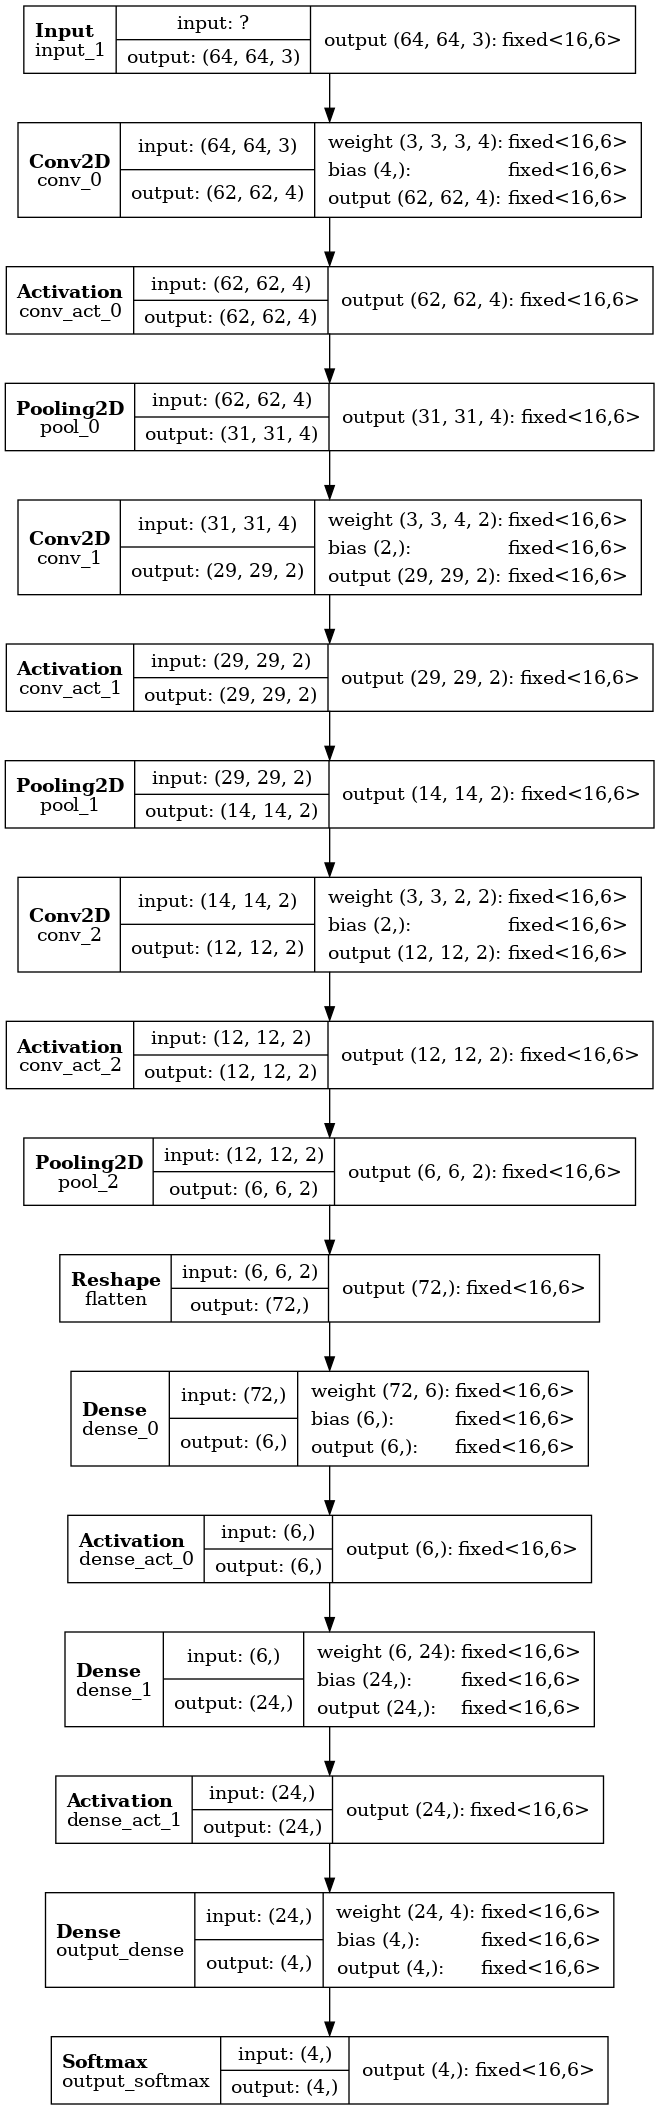

In [27]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv_0, layer type: Conv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: bn_conv_0, layer type: BatchNormalization, input shapes: [[None, 62, 62, 4]], output shape: [None, 62, 62, 4]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 62, 62, 4]], output shape: [None, 62, 62, 4]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv_1, layer type: Conv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 2]
Layer name: bn_conv_1, layer type: BatchNormalization, input shapes: [[None, 29, 29, 2]], output shape: [None, 29, 29, 2]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 29, 29, 2]], output shape: [None, 29, 29, 2]
Layer name: pool_1, layer type: MaxPooling2D, input shapes

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

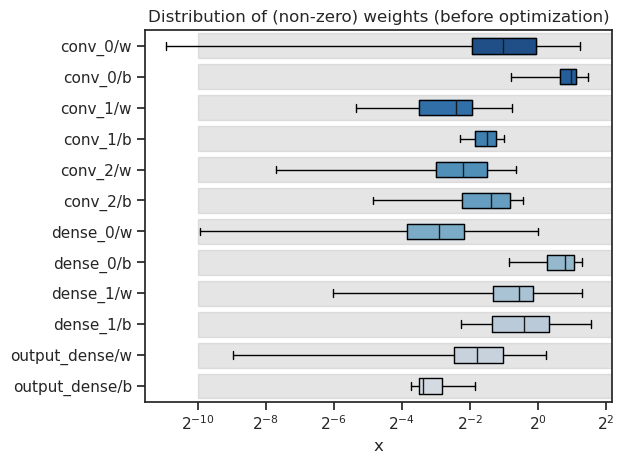

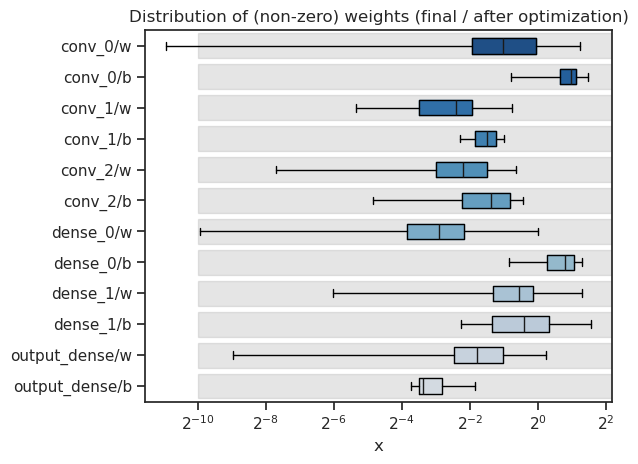

In [28]:
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model)

The colored boxes are the distribution of the weights of the model, and the gray band illustrates the numerical range covered by the chosen fixed point precision. As we configured, this model uses a precision of ap_fixed<16,6> for all layers of the model. Let's now build our QKeras model

In [29]:
# Then the QKeras model
hls_config_q = hls4ml.utils.config_from_keras_model(qmodel, granularity='name')
hls_config_q['Model']['ReuseFactor'] = 1
hls_config_q['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config_q['LayerName']['output_softmax']['Strategy'] = 'Stable'
    
#plotting.print_dict(hls_config_q)
#for k in hls_config_q:
#   print('\n',k,hls_config_q[k],'\n')

import json
print(json.dumps(hls_config_q, indent = 4)) #chipSkywalker 2024.07.04 to fix no attribute print_dict error

cfg_q = hls4ml.converters.create_config(backend='Vitis')  # chipSkywalker modified to use Vitis HLS
cfg_q['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg_q['HLSConfig'] = hls_config_q
cfg_q['KerasModel'] = qmodel
cfg_q['OutputDir'] = 'quantized_pruned_cnn/'
cfg_q['Part'] = TARGET_FPGA_DEVICE  # chipSkywalker use Target Device set at beginning
#cfg_q['XilinxPart'] = TARGET_FPGA_DEVICE
#cfg_q['XilinxPart'] = 'xc7z020clg484-1'

hls_model_q = hls4ml.converters.keras_to_hls(cfg_q)
hls_model_q.compile()

Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 62, 62, 4]], output shape: [None, 62, 62, 4]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 2]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 29, 29, 2]], output shape: [None, 29, 29, 2]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 2]], output shape: [None, 14, 14, 2]
Layer name: fused_convbn_2, layer type: QConv2DBatchnorm, input shapes: [[None, 14, 14, 2]], output shape: [None, 12, 12, 2]
Layer name: conv_act_2, laye

Done


Let's plot the model and profile the weights too

Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 62, 62, 4]], output shape: [None, 62, 62, 4]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 2]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 29, 29, 2]], output shape: [None, 29, 29, 2]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 2]], output shape: [None, 14, 14, 2]
Layer name: fused_convbn_2, layer type: QConv2DBatchnorm, input shapes: [[None, 14, 14, 2]], output shape: [None, 12, 12, 2]
Layer name: conv_act_2, laye

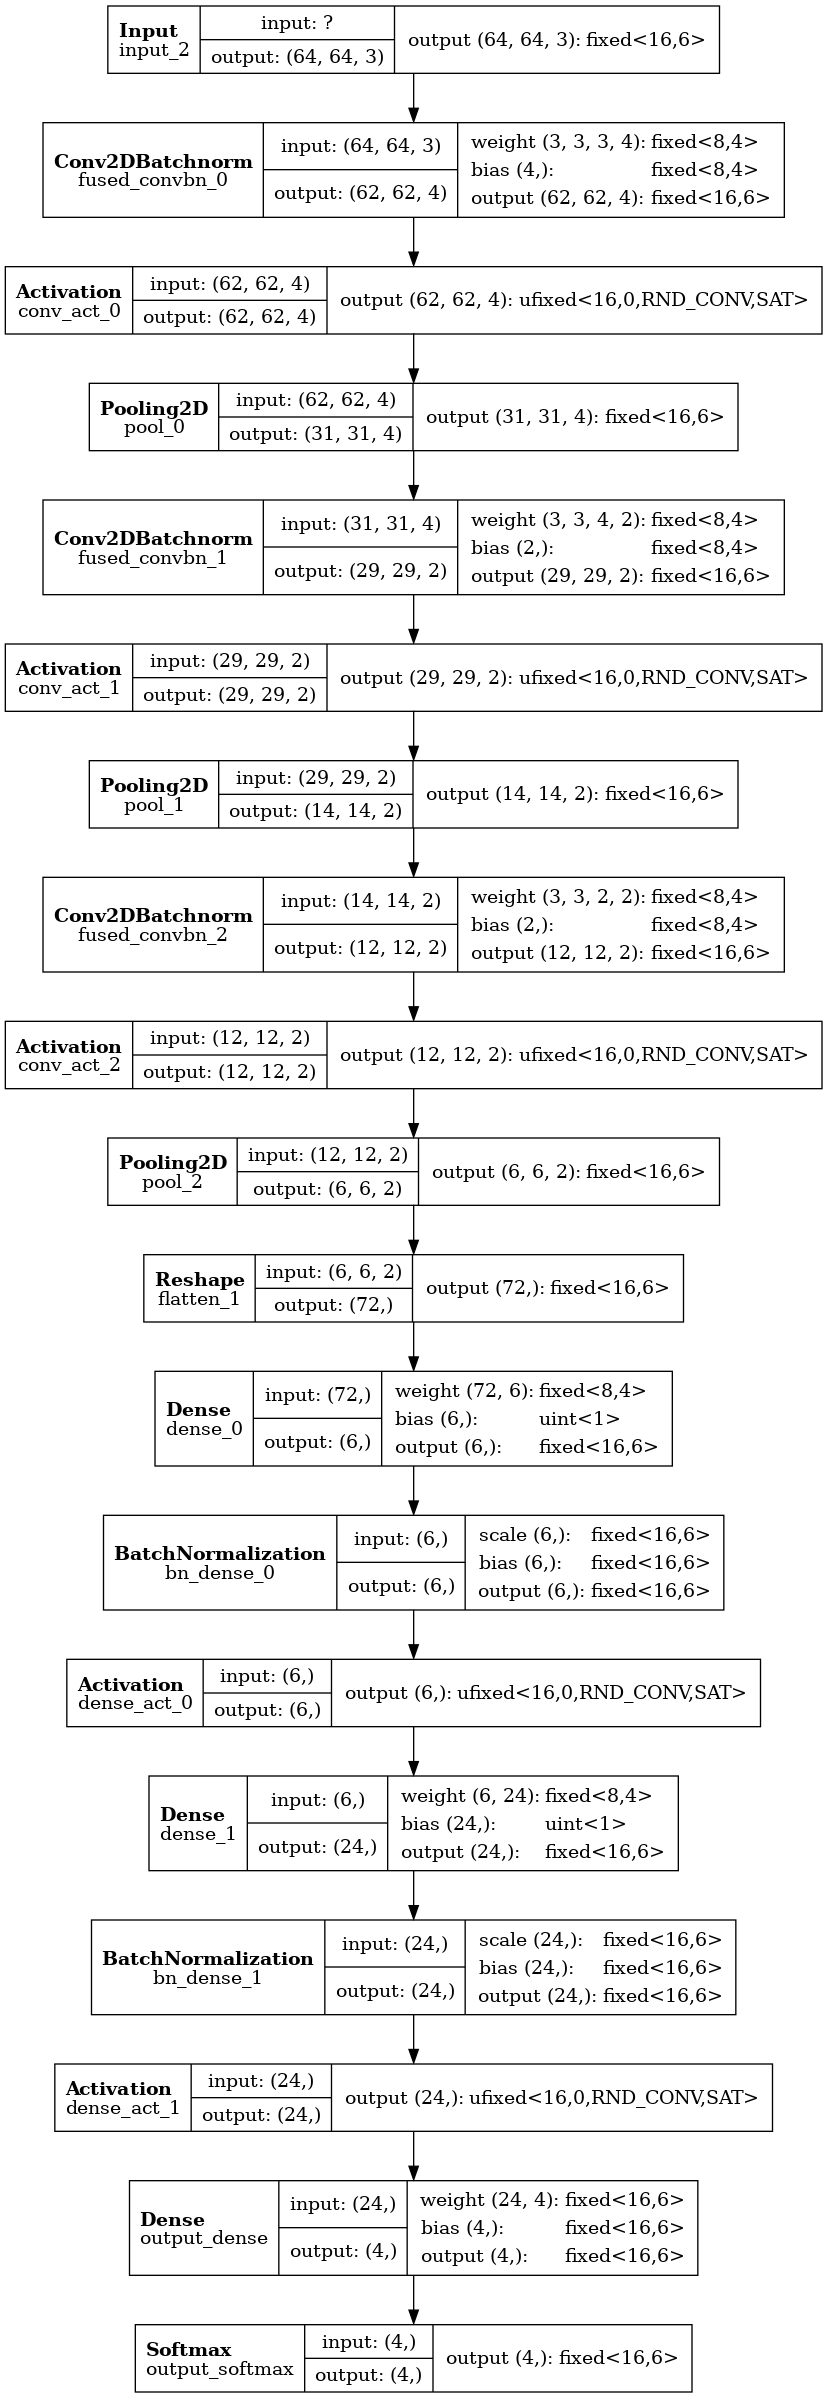

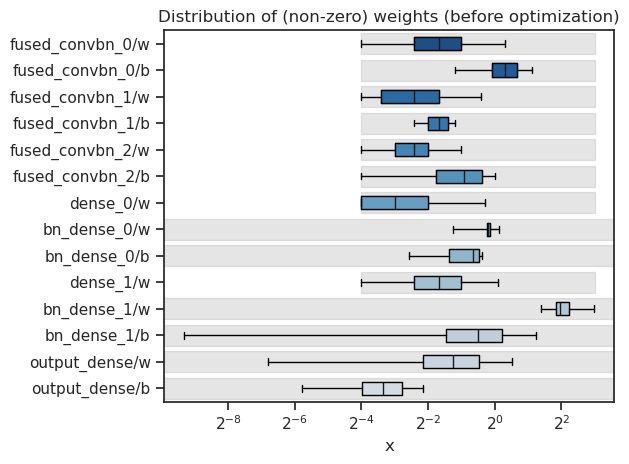

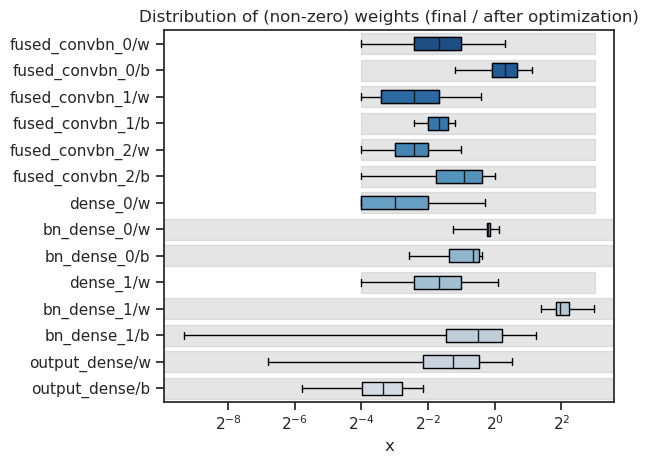

In [30]:
hls4ml.model.profiling.numerical(model=qmodel, hls_model=hls_model_q)
hls4ml.utils.plot_model(hls_model_q, show_shapes=True, show_precision=True, to_file=None)

### Accuracy with bit-accurate emulation
### If you learn our Unit8/Unit9, you will understand it is doing C Simulation, it takes some time to predict all test dataset
##  But it is still faster than RTL simulation
Let's check that the hls4ml accuracy matches the original. This usually takes some time, so let's do it over a reduced dataset

In [31]:
X_test_reduced = X_test[:100]
Y_test_reduced = Y_test[:100]

#chipskywalker, test dataset is not large, let's predict them all
X_test_reduced = X_test
Y_test_reduced = Y_test

y_predict = model.predict(X_test_reduced)
y_predict_hls4ml = hls_model.predict(np.ascontiguousarray(X_test_reduced))

y_predict_q = qmodel.predict(X_test_reduced)
y_predict_hls4ml_q = hls_model_q.predict(np.ascontiguousarray(X_test_reduced))

16/16 [==============================] - 0s 2ms/step


In [32]:
predict_baseline = y_predict
test_score_baseline = y_predict_hls4ml

predict_qkeras = y_predict_q
test_score_qkeras = y_predict_hls4ml_q

from sklearn.metrics import accuracy_score

accuracy_hls4ml_keras = float(accuracy_score(np.argmax(Y_test_reduced, axis=1), np.argmax(y_predict_hls4ml, axis=1)))
accuracy_hls4ml_qkeras = float(accuracy_score(np.argmax(Y_test_reduced, axis=1), np.argmax(y_predict_hls4ml_q, axis=1)))

print("Accuracy hls4ml Float Keras     : {} %".format(accuracy_hls4ml_keras*100))
print("Accuracy hls4ml Quantized QKeras: {} %".format(accuracy_hls4ml_qkeras*100))
#print('Keras accuracy = {} , QKeras 6-bit accuracy = {}'.format(test_score_baseline[1], test_score_qkeras[1]))

Accuracy hls4ml Float Keras     : 74.0234375 %
Accuracy hls4ml Quantized QKeras: 75.9765625 %


### Accuracy of Quantized Pruned hls4ml model is as good as Float model, Excellent !!!  

Plotting ROC for labels ['0', '1', '2', '3']


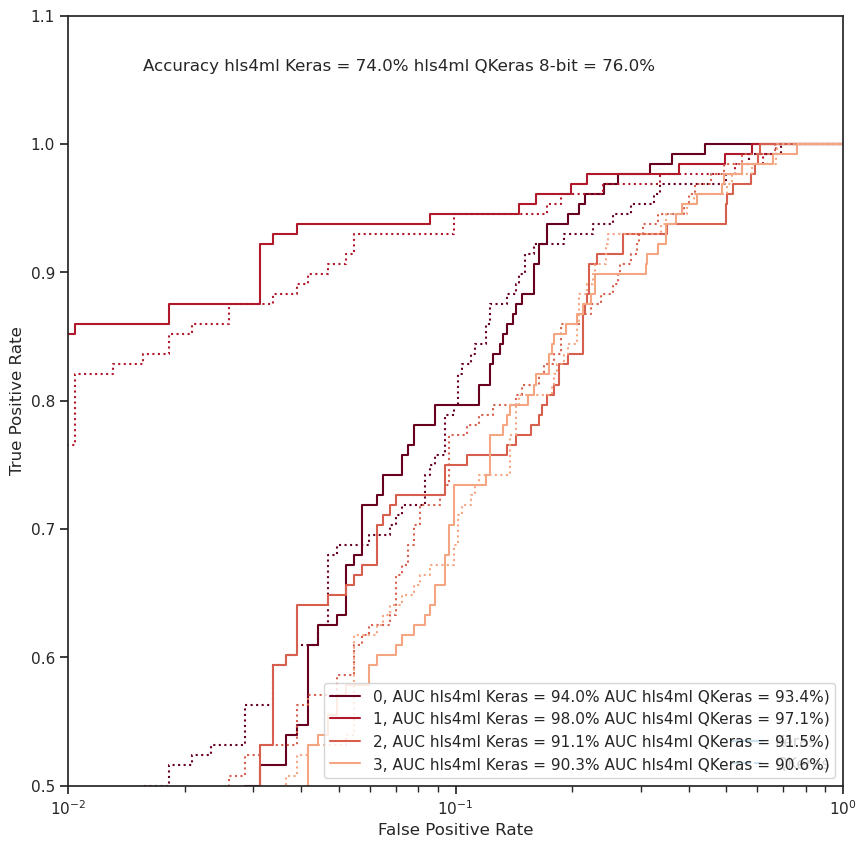

In [33]:
#chipSkywalker 2024.07.04, there is AttributeError: module 'plotting' has no attribute 'makeRoc' at below def plotROC, 
# so we copy and modify for hls4ml float pruned model and hls4ml pruned 8bits qmodel ROC/AUC curve
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


labels = ['%i' % nr for nr in range(0, n_classes)]  # If you want to look at all the labels
# labels = ['0','1','9'] # Look at only a few labels, here for digits 0, 1 and 9
print('Plotting ROC for labels {}'.format(labels))

df = pd.DataFrame()
df_q = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}
fpr_q = {}
tpr_q = {}
auc1_q = {}
%matplotlib inline
colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
fig, ax = plt.subplots(figsize=(10, 10))
for i, label in enumerate(labels):
    df[label] = Y_test_reduced[:, int(label)]
    df[label + '_pred'] = predict_baseline[:, int(label)]
    fpr[label], tpr[label], threshold = metrics.roc_curve(df[label], df[label + '_pred'])
    auc1[label] = metrics.auc(fpr[label], tpr[label])

    df_q[label] = Y_test_reduced[:, int(label)]
    df_q[label + '_pred'] = predict_qkeras[:, int(label)]
    fpr_q[label], tpr_q[label], threshold_q = metrics.roc_curve(df_q[label], df_q[label + '_pred'])
    auc1_q[label] = metrics.auc(fpr_q[label], tpr_q[label])

    plt.plot(
        fpr[label],
        tpr[label],
        label=r'{}, AUC hls4ml Keras = {:.1f}% AUC hls4ml QKeras = {:.1f}%)'.format(label, auc1[label] * 100, auc1_q[label] * 100),
        linewidth=1.5,
        c=colors[i],
        linestyle='solid',
    )
    plt.plot(fpr_q[label], tpr_q[label], linewidth=1.5, c=colors[i], linestyle='dotted')

plt.semilogx()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.xlim(0.01, 1.0)
plt.ylim(0.5, 1.1)
plt.legend(loc='lower right')
plt.figtext(
    0.2,
    0.83,
    #r'Accuracy Keras = {:.1f}% QKeras 8-bit = {:.1f}%'.format(test_score_baseline[1] * 100, test_score_qkeras[1] * 100),
    r'Accuracy hls4ml Keras = {:.1f}% hls4ml QKeras 8-bit = {:.1f}%'.format(accuracy_hls4ml_keras*100, accuracy_hls4ml_qkeras*100),
    wrap=True,
    horizontalalignment='left',
    verticalalignment='center',
)
from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['Keras', 'QKeras'], loc='lower right', frameon=False)
ax.add_artist(leg)

Looks good! Let's synthesize the models. 
## Logic synthesis
This takes quite a while for CNN models, up to one hour for the models considered here. In the interest of time, we have therefore provided the neccessary reports for the models considered. You can also synthesize them yourself if you have time, and as usual follow the progress using ``tail -f pruned_cnn/vivado_hls.log`` and ``tail -f quantized_pruned_cnn/vivado_hls.log``.

Remember to set your final target part at beginning : TARGET_FPGA_DEVICE

In [ ]:
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

synth = True  # Only if you want to Vivado synthesize the models yourself (>1h per model) rather than look at the provided reports
export_ip = True # export IP for later hardware Vivado integration

if synth:
    hls_model.build(csim=False, synth=True, vsynth=True, export=export_ip)
    hls_model_q.build(csim=False, synth=True, vsynth=True, export=export_ip)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2020.2 (64-bit)
  **** SW Build 3064766 on Wed Nov 18 09:12:47 MST 2020
  **** IP Build 3064653 on Wed Nov 18 14:17:31 MST 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /mnt/Data/Xilinx/Vitis_HLS/2020.2/scripts/vitis_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/mnt/Data/Xilinx/Vitis_HLS/2020.2/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'ck' on host 'ck-ubuntu2204' (Linux_x86_64 version 6.8.0-45-generic) on Mon Oct 21 14:05:27 CST 2024
INFO: [HLS 200-10] On os Ubuntu 22.04.5 LTS
INFO: [HLS 200-10] In directory '/mnt/Data/digital_design/AI_NPU_CNN_3/Covid19-CNN/pruned_cnn'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/mnt/Data/digital_design/AI_NPU_CNN_3/Covid19-CNN/pruned_cnn/myproject_prj'.
INFO: [HLS 200-1510] Running: set_top myproject

In [ ]:
def getReports(indir):
    data_ = {}

    report_vsynth = Path('{}/vivado_synth.rpt'.format(indir))
    report_csynth = Path('{}/myproject_prj/solution1/syn/report/myproject_csynth.rpt'.format(indir))

    if report_vsynth.is_file() and report_csynth.is_file():
        print('Found valid vsynth and synth in {}! Fetching numbers'.format(indir))

        # Get the resources from the logic synthesis report
        with report_vsynth.open() as report:
            lines = np.array(report.readlines())
            if REPORT_USE_CLB==1: # MPSoC FPGA report
                data_['lut'] = int(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[2])
                data_['ff'] = int(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[2])
            else: #7 series FPGA report 
                data_['lut'] = int(lines[np.array(['Slice LUTs*' in line for line in lines])][0].split('|')[2])
                data_['ff'] = int(lines[np.array(['Slice Registers' in line for line in lines])][0].split('|')[2]) 
            data_['bram'] = float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[2])
            data_['dsp'] = int(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[2])
            if HLS_REPORT_FORMAT_2023_2==0: # HLS 2020.2 report format 
                if REPORT_USE_CLB==1:
                    data_['lut_Util%'] = float(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[5]) 
                    data_['ff_Util%'] = float(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[5])         
                else:
                    data_['lut_Util%'] = float(lines[np.array(['Slice LUTs*' in line for line in lines])][0].split('|')[5])
                    data_['ff_Util%'] = float(lines[np.array(['Slice Registers' in line for line in lines])][0].split('|')[5])
                data_['bram_Util%'] = float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[5])
                data_['dsp_Util%'] = float(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[5])
            else:
                if REPORT_USE_CLB==1:
                    data_['lut_Util%'] = float(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[6]) 
                    data_['ff_Util%'] = float(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[6])         
                else:
                    data_['lut_Util%'] = float(lines[np.array(['Slice LUTs*' in line for line in lines])][0].split('|')[6])
                    data_['ff_Util%'] = float(lines[np.array(['Slice Registers' in line for line in lines])][0].split('|')[6])
                data_['bram_Util%'] = float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[6])
                data_['dsp_Util%'] = float(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[6])                

        with report_csynth.open() as report:
            lines = np.array(report.readlines())
            lat_line = lines[np.argwhere(np.array(['Latency (cycles)' in line for line in lines])).flatten()[0] + 3]
            data_['latency_clks'] = int(lat_line.split('|')[2])
            #data_['latency_us'] = float(lat_line.split('|')[2]) * 5.0 / 1000.0
            data_['latency_ms'] = (lat_line.split('|')[4])
            data_['latency_ii'] = int(lat_line.split('|')[6])
            data_['Estimated clock ns'] = (lines[np.array(['ap_clk' in line for line in lines])][0].split('|')[3])
         

    return data_

In [ ]:
from pathlib import Path
import pprint

data_pruned_ref = getReports('pruned_cnn')
print("\n Resource usage and latency: Pruned + Float")
pprint.pprint(data_pruned_ref)

#we care more about quantized pruned model hls report
data_quantized_pruned = getReports('quantized_pruned_cnn')
print("\n Resource usage and latency: Pruned + quantized")
pprint.pprint(data_quantized_pruned)